In [32]:
import os
import time
import math
import scipy.io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle



In [33]:
mat = scipy.io.loadmat('H2.mat')
t = 14*3000
subcarriers = 8
MIMO = 1
H = mat['H'].T
noise = True
#noise = False
SNR_dB = 20
if noise:
  mat_noise = scipy.io.loadmat('H_noise2.mat')
  H_noisy = mat_noise['H_noise'].T
else:
  H_noisy = np.zeros_like(H)

In [34]:
# Get to operate for both train and test dataset

def dataset_MIMO(dataset, noisy_dataset, step, lookback=4, samples=100000, model_type='GRU', offset=0, horizon=0):
  horizon = horizon-step

  # Define lookback period and split inputs/labels
  #subcarriers = 624 # Already defined above
  sc = math.ceil(samples/(t-lookback*step))

  if sc <= subcarriers:
    inputs = np.zeros((sc*(t-lookback*step), lookback, 2*MIMO))
    labels = np.zeros((sc*(t-lookback*step), 2*MIMO))
    labels_clean = np.zeros((sc*(t-lookback*step), 2*MIMO))

  else:
    while sc <= subcarriers:
      samples = samples*subcarriers/sc
      sc = math.ceil(samples/(t-lookback*step))

    print('Observe that the number of data points available in this setting are ' + str(samples))
    inputs = np.zeros((samples, lookback, 2*MIMO))
    labels = np.zeros((samples, 2*MIMO))
    labels_clean = np.zeros((samples, 2*MIMO))

  jump = 1
  for i in range(0, sc*jump, jump):
      p = 2*t*(i+offset) # To jump to the current subcarrier
      for j in range(2*lookback*step, 2*t, 2):
        for m in range(MIMO):

          q = 2*subcarriers*t*m # To jump to the current antenna array (MIMO)
          s = q+p+j-(2*lookback*step) # First index for retrieving data. The current position minus the lookback
          e = q+p+j # Last index for retrieving data

          c = int(i/jump)*(t-lookback*step) + int(j/2)-lookback*step # The current position to store data

          inputs[c, :, 2*m] = dataset[s:e:2*step].reshape(lookback) + noisy_dataset[s:e:2*step].reshape(lookback)
          inputs[c, :, 2*m+1] = dataset[s+1:e+1:2*step].reshape(lookback) + noisy_dataset[s+1:e+1:2*step].reshape(lookback)

          labels_clean[c, 2*m:2 + 2*m] = dataset[e+2*horizon:e+2*horizon+2].reshape(-1,2)
          labels[c, 2*m:2 + 2*m] = noisy_dataset[e+2*horizon:e+2*horizon+2].reshape(-1,2) + dataset[e+2*horizon:e+2*horizon+2].reshape(-1,2)

  inputs = inputs[:samples]
  labels = labels[:samples]
  labels_clean = labels_clean[:samples]

  return inputs, labels, labels_clean

In [35]:
# Get to operate for both train and test dataset

def dataset_MIMO_trans(dataset, noisy_dataset, step, lookback=4, samples=100000, model_type='GRU', offset=0, horizon=0, past=0):
  h = int(horizon/step)
  horizon = horizon-step

  # Define lookback period and split inputs/labels
  #subcarriers = 624 # Already defined above
  sc = math.ceil(samples/(t-lookback*step))

  if sc <= subcarriers:
    inputs = np.zeros((sc*(t-lookback*step), lookback, 2*MIMO))
    labels = np.zeros((sc*(t-lookback*step), past+h, 2*MIMO))
    labels_clean = np.zeros((sc*(t-lookback*step), past+h, 2*MIMO))

  else:
    while sc <= subcarriers:
      samples = samples*subcarriers/sc
      sc = math.ceil(samples/(t-lookback*step))

    print('Observe that the number of data points available in this setting are ' + str(samples))
    inputs = np.zeros((samples, lookback, 2*MIMO))
    labels = np.zeros((samples, past+h, 2*MIMO))
    labels_clean = np.zeros((samples, past+h, 2*MIMO))

  jump = 20
  for i in range(0, sc*jump, jump):
      p = 2*t*(i+offset) # To jump to the current subcarrier
      for j in range(2*lookback*step, 2*t, 2):
        for m in range(MIMO):

          q = 2*subcarriers*t*m # To jump to the current antenna array (MIMO)
          s = q+p+j-(2*lookback*step) # First index for retrieving data. The current position minus the lookback
          e = q+p+j # Last index for retrieving data

          c = int(i/jump)*(t-lookback*step) + int(j/2)-lookback*step # The current position to store data

          inputs[c, :, 2*m] = dataset[s:e:2*step].reshape(lookback) + noisy_dataset[s:e:2*step].reshape(lookback)
          inputs[c, :, 2*m+1] = dataset[s+1:e+1:2*step].reshape(lookback) + noisy_dataset[s+1:e+1:2*step].reshape(lookback)

          labels_clean[c, :, 2*m] = dataset[e-2*past*step:e+2*horizon+2:2*step,0]#.reshape(-1,1+past+h,2) #::ts_step , past*step
          labels_clean[c, :, 2*m+1] = dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0]#.reshape(-1,1+past+h,2) #::ts_step , past*step
          labels[c, :, 2*m] = noisy_dataset[e-2*past*step:e+2*horizon+2:2*step,0] + dataset[e-2*past*step:e+2*horizon+2:2*step,0]#.reshape(-1,1+past+h,2)
          labels[c, :, 2*m+1] = noisy_dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0] + dataset[e-2*past*step+1:e+2*horizon+2+1:2*step,0]#.reshape(-1,1+past+h,2)

  inputs = inputs[:samples]
  labels = labels[:samples]
  labels_clean = labels_clean[:samples]



  return inputs, labels, labels_clean

In [36]:
def scaler_transform(X_list):#, x_max, x_min):
  if type(X_list) == list:
    X_scaled = []
    for X in X_list:
      X_scaled.append((X-x_min)/(x_max-x_min))
  else:
    X_scaled = (X_list[0]-x_min)/(x_max-x_min)

  return X_scaled


def scaler_inv_transform(X_list):#, x_max, x_min):
  if type(X_list) == list:
    X_std = []
    for X in X_list:
      X_std.append(X * (x_max-x_min)+x_min)

  else:
    X_std = X_list * (x_max-x_min)+x_min

  return X_std

In [37]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [38]:
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what
    the positional encoding layer does and why it is needed:

    "Since our model contains no recurrence and no convolution, in order for the
    model to make use of the order of the sequence, we must inject some
    information about the relative or absolute position of the tokens in the
    sequence." (Vaswani et al, 2017)
    Adapted from:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self,
        dropout: float=0.1,
        max_seq_len: int=5000,
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model

        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        #pe = torch.zeros(max_seq_len, 1, d_model)
        pe = torch.zeros(max_seq_len, d_model)

        #pe[:, 0, 0::2] = torch.sin(position * div_term)
        #pe[:, 0, 1::2] = torch.cos(position * div_term)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        #pe = torch.zeros(1, max_seq_len, d_model)
        #pe[0, :, 0::2] = torch.sin(position * div_term)
        #pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [39]:
class TimeSeriesTransformer(nn.Module):

    def __init__(self,
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        max_seq_len: int,
        out_seq_len: int=1,
        dim_val: int=512,
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2,
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=2*MIMO
        ):

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__()

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )

        self.linear_mapping = nn.Linear(
            in_features=dim_val,
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            batch_first=batch_first,
            max_seq_len=max_seq_len
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers,
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers,
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None,
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]

        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input,
                 (S, N, E) if batch_first=False or (N, S, E) if
                 batch_first=True, where S is the source sequence length,
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input,
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if
                 batch_first=True, where T is the target sequence length,
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length.
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

In [40]:
def get_src_trg(
        self,
        sequence: torch.Tensor,
        enc_seq_len: int,
        target_seq_len: int
        ): #-> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence.
        Args:
            sequence: tensor, a 1D tensor of length n where
                    n = encoder input length + target sequence length
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the
                            one against which the model output is compared)
        Return:
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss.

        """
        #print("Called dataset.TransformerDataset.get_src_trg")
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"

        #print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len]

        # decoder input. As per the paper, it must have the same dimension as the
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        trg = trg[:, 0]

        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)


        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]


        # We only want trg_y to consist of the target variable not any potential exogenous variables
        trg_y = trg_y[:, 0]

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len]

In [41]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e.
              the length of the input sequence to the model),
              and for tgt masking, this must be target sequence length
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

In [42]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.tanh(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

        return hidden

In [37]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.tanh(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [37]:
# CNN
class CNNNet1(nn.Module):
      def __init__(self):
        super(CNNNet1, self).__init__()
        self.kernel_size = 6

        # conv layer
        downsample = self._downsample(32, 32)
        self.conv1 = nn.Conv1d(in_channels=2,
                               out_channels=4,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
                # ReLU
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.maxpool1d = nn.MaxPool1d(kernel_size = self.kernel_size,
                                      stride = downsample,
                                      padding = self._padding(downsample))

        # conv layer
        downsample = self._downsample(32, 32)
        self.conv2 = nn.Conv1d(in_channels=4,
                               out_channels=8,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
         # conv layer
        downsample = self._downsample(32, 16)
        self.conv3 = nn.Conv1d(in_channels=8,
                               out_channels=16,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        # conv layer
        downsample = self._downsample(16, 8)
        self.conv4 = nn.Conv1d(in_channels=16,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=80,
                             out_features=2)



        self.sigmoid = nn.Sigmoid()

      def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

      def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


      def forward(self, x):
        x= x.transpose(2,1)

        x = self.leaky_relu(self.conv1(x))
        x = self.maxpool1d(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.maxpool1d(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.maxpool1d(x)
        #x = self.leaky_relu(self.conv4(x))
        #x = self.maxpool1d(x)
        #x = self.relu(self.conv2(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        #x = self.sigmoid(x)

        return x


In [38]:
# MLP
class MLPNet(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 1024),
      nn.ReLU(),
      nn.Linear(1024, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, output_dim)
    )

  def forward(self, x):
    return self.layers(x)

In [43]:
def AR_coeff_LS(data, lookback, la):
  F = np.zeros([lookback, lookback])
  A = np.zeros([len(data), 2*MIMO, lookback])
  for i in range(len(data)):
    for m in range(2*MIMO):
      for l in range(lookback):
        b = np.flip(data[i, l:l+lookback, m])
        F[l,:] = b
      a = np.matrix(data[i, lookback:, m]).T*F[0,0]

      c = F*F[0,0]
      ca = np.linalg.inv(c.T@c + la*np.eye(c.shape[0]))@(c.T)@a
      A[i, m, :] = ca.T

  return A

In [44]:
def train(model, train_loader, model_type='regular'):
    model.train()
    train_loss = 0

    if model_type in ['GRU', 'LSTM']:
      h = model.init_hidden(batch_size)
      for x, label, clean_label in train_loader:
          optimizer.zero_grad()
          out, _ = model(x.to(device).float(), h)
          loss = criterion(out, label.to(device).float())
          loss.backward()#retain_graph=True)
          optimizer.step()
          loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy())),
                           torch.from_numpy(clean_label.numpy()))
          train_loss += loss.item()


    elif model_type == 'TRANS':
      for x, label, clean_label in train_loader:
        optimizer.zero_grad()
        src = x[:,:enc_seq_len,:]
        tgt = x[:,-dec_seq_len:,:]
        out = model(src.to(device).float(), tgt.to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
        loss = criterion(out, label.to(device).float())
        loss.backward()#retain_graph=True)
        optimizer.step()
        loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy()))[:,-1,:],
                         torch.from_numpy(clean_label.numpy())[:,-1,:])
        train_loss += loss.item()

    else:
      for i, data in enumerate(train_loader, 0):
          x, label, clean_label = data
          optimizer.zero_grad()
          out = model(x.to(device).float())
          loss = criterion(out, label.to(device).float())
          loss.backward()
          optimizer.step()
          loss = criterion(torch.from_numpy(scaler_inv_transform(out.cpu().detach().numpy())),
                           torch.from_numpy(clean_label.numpy()))
          train_loss += loss.item()

    optimizer.zero_grad()

    return train_loss/len(train_loader)

In [45]:
def evaluate(model, test_x, test_y_clean, test_y, model_type, epoch):
    model.eval()
    start_time = time.time()
    inp = torch.from_numpy(test_x)
    target = torch.from_numpy(test_y_clean)
    labs_dist = torch.from_numpy(test_y)
    target_measured = scaler_inv_transform(labs_dist.numpy())

    if (model_type == 'GRU' or model_type == 'LSTM'):
      h = model.init_hidden(inp.shape[0])
      out, _ = model(inp.to(device).float(), h)
      output = scaler_inv_transform(out.cpu().detach().numpy())
      loss = criterion(torch.from_numpy(output), target)

    elif model_type == 'TRANS':
      src = inp[:,:enc_seq_len,:]
      tgt = inp[:,-dec_seq_len:,:]
      start_time = time.time()
      out = model(src.to(device).float(), tgt.to(device).float(), src_mask=src_mask.to(device).float(), tgt_mask=tgt_mask.to(device).float())
      output = scaler_inv_transform(out.cpu().detach().numpy())
      loss = criterion(torch.from_numpy(output)[:,-1,:],
                       target[:,-1,:])

    else:
      out = model(inp.to(device).float())
      output = scaler_inv_transform(out.cpu().detach().numpy())
      loss = criterion(torch.from_numpy(output), target)

    test_loss = loss.item()
    target = target.numpy()
    optimizer.zero_grad()

    return test_loss

In [46]:
def epoch_loop(model, train_loader, test_x, test_y, test_y_clean, epochs, lr_scheduler1, model_type = 'GRU'):
  print('Started with ' + model_type)

  training_loss = np.zeros([epochs])
  validation_loss = np.zeros([epochs])
  start_time = time.time()
  best_loss = 1

  for epoch in range(1,epochs+1):
    training_loss[epoch-1] = train(model, train_loader, model_type)
    validation_loss[epoch-1] = evaluate(model, test_x, test_y_clean, test_y, model_type, epoch)

    if 1:#epoch%10 == 0:
      current_time = time.time()
      print("Epoch {}/{} Done".format(epoch, epochs))
      print("Total Time Elapsed: %.2f minutes" %((current_time-start_time)/60))
      print("Training loss: %.6f " %(training_loss[epoch-1]))
      print("Validation loss: %.6f " %(validation_loss[epoch-1]))

    if lr_scheduler1:
      lr_scheduler1.step()

  return training_loss, validation_loss

In [47]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [48]:
lr = 0.00008
lr_rnn = 0.00008
lr_trans = 0.00008
ts_step = np.array([14])

#horizons = np.array([14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 196, 210])
horizons = np.array([14, 28, 42, 56, 70])
#horizons = np.array([14, 28, 42, 56, 70, 84, 98, 112, 126, 140, 154, 168, 182, 196, 210, 224, 238, 252])
train_samples = 9000
test_samples = 1000
samples = 10000
lookback = 5
#lookback = 10
#lookback = 20
order = 4
test_sc_offset = 5
batch_size = 32
hidden = 150
epochs = 200
epochs_rnn = 200
criterion = nn.MSELoss()

file = 'performance_SNR20_1_lookback5_new.csv'
if os.path.isfile(file):
  performance_df = pd.read_csv(file, index_col=0)
  cols = list(performance_df.columns)
  if len(performance_df.index) is not len(horizons):
    mask = np.isin(horizons, np.array(performance_df.index))
    diff = horizons[np.invert(mask)]
    for d in diff:
      performance_df.loc[d] = np.zeros(len(cols))
else:
  performance_df = pd.DataFrame(columns=['Outdated', 'MLP', 'CNN', 'GRU', 'LSTM', 'KF', 'Transformer'], index=horizons)
  for col in performance_df.columns:
    performance_df[col].values[:] = 0

In [49]:
outdated_error =        np.zeros([len(horizons)])
training_loss_gru =     np.zeros([len(horizons), epochs_rnn])
validation_loss_gru =   np.zeros([len(horizons), epochs_rnn])
training_loss_lstm =    np.zeros([len(horizons), epochs_rnn])
validation_loss_lstm =  np.zeros([len(horizons), epochs_rnn])
training_loss_mlp =     np.zeros([len(horizons), epochs])
validation_loss_mlp =   np.zeros([len(horizons), epochs])
training_loss_cnn =     np.zeros([len(horizons), epochs])
validation_loss_cnn =   np.zeros([len(horizons), epochs])
training_loss_transformer =   np.zeros([len(horizons), epochs])
validation_loss_transformer = np.zeros([len(horizons), epochs])
y_pred = np.zeros([test_samples, 2*MIMO])
y_pred_err = np.zeros([len(horizons)])

In [50]:
def plot_losses(training_loss, validation_loss, epochs, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), training_loss, label='Training Loss',color='blue')
    plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss', color='red')
    plt.xlabel('Epochs',fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    #plt.title(f'Training and Validation Loss Convergence for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()          

Started with GRU
Epoch 1/200 Done
Total Time Elapsed: 0.03 minutes
Training loss: 0.991537 
Validation loss: 0.627032 
Epoch 2/200 Done
Total Time Elapsed: 0.06 minutes
Training loss: 0.491089 
Validation loss: 0.482185 
Epoch 3/200 Done
Total Time Elapsed: 0.08 minutes
Training loss: 0.353261 
Validation loss: 0.302040 
Epoch 4/200 Done
Total Time Elapsed: 0.11 minutes
Training loss: 0.260922 
Validation loss: 0.218283 
Epoch 5/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.223851 
Validation loss: 0.194744 
Epoch 6/200 Done
Total Time Elapsed: 0.15 minutes
Training loss: 0.209151 
Validation loss: 0.184484 
Epoch 7/200 Done
Total Time Elapsed: 0.16 minutes
Training loss: 0.198492 
Validation loss: 0.175993 
Epoch 8/200 Done
Total Time Elapsed: 0.19 minutes
Training loss: 0.188226 
Validation loss: 0.167815 
Epoch 9/200 Done
Total Time Elapsed: 0.21 minutes
Training loss: 0.178762 
Validation loss: 0.151768 
Epoch 10/200 Done
Total Time Elapsed: 0.23 minutes
Training loss:

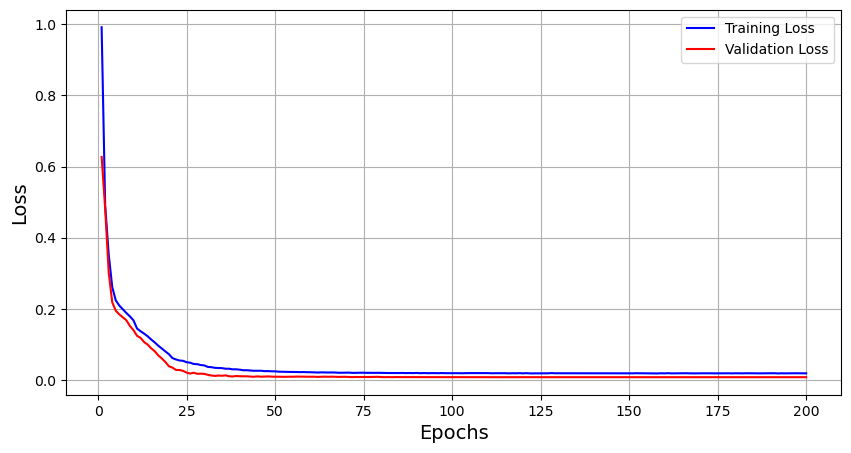

Sampling time 1.0 ms done.
Started with GRU
Epoch 1/200 Done
Total Time Elapsed: 0.03 minutes
Training loss: 1.052379 
Validation loss: 0.617581 
Epoch 2/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 0.542936 
Validation loss: 0.540589 
Epoch 3/200 Done
Total Time Elapsed: 0.07 minutes
Training loss: 0.458511 
Validation loss: 0.441601 
Epoch 4/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.366805 
Validation loss: 0.339669 
Epoch 5/200 Done
Total Time Elapsed: 0.11 minutes
Training loss: 0.323788 
Validation loss: 0.301302 
Epoch 6/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.304701 
Validation loss: 0.285573 
Epoch 7/200 Done
Total Time Elapsed: 0.15 minutes
Training loss: 0.290274 
Validation loss: 0.270267 
Epoch 8/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.278331 
Validation loss: 0.254067 
Epoch 9/200 Done
Total Time Elapsed: 0.19 minutes
Training loss: 0.265804 
Validation loss: 0.239878 
Epoch 10/200 Done
Total Time Elapsed: 

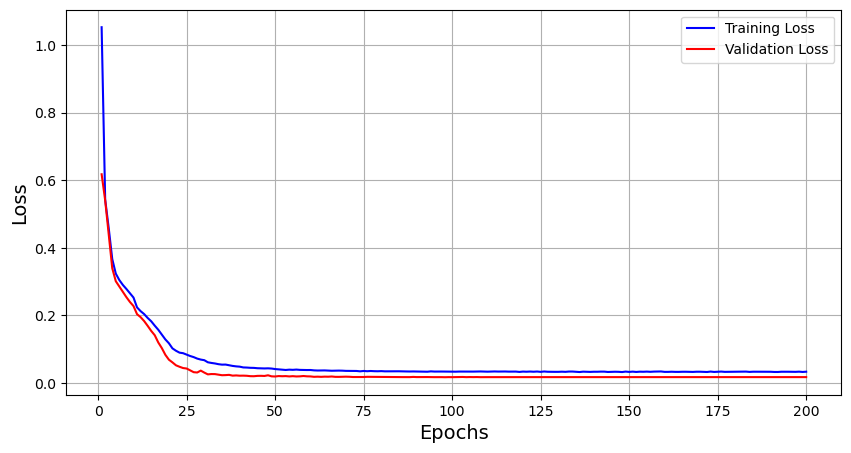

Sampling time 2.0 ms done.
Started with GRU
Epoch 1/200 Done
Total Time Elapsed: 0.03 minutes
Training loss: 1.395007 
Validation loss: 0.657175 
Epoch 2/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 0.591295 
Validation loss: 0.610233 
Epoch 3/200 Done
Total Time Elapsed: 0.07 minutes
Training loss: 0.557178 
Validation loss: 0.570249 
Epoch 4/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.519655 
Validation loss: 0.518042 
Epoch 5/200 Done
Total Time Elapsed: 0.11 minutes
Training loss: 0.471378 
Validation loss: 0.469587 
Epoch 6/200 Done
Total Time Elapsed: 0.12 minutes
Training loss: 0.437177 
Validation loss: 0.430600 
Epoch 7/200 Done
Total Time Elapsed: 0.14 minutes
Training loss: 0.415198 
Validation loss: 0.410767 
Epoch 8/200 Done
Total Time Elapsed: 0.16 minutes
Training loss: 0.399950 
Validation loss: 0.393114 
Epoch 9/200 Done
Total Time Elapsed: 0.18 minutes
Training loss: 0.386297 
Validation loss: 0.376597 
Epoch 10/200 Done
Total Time Elapsed: 

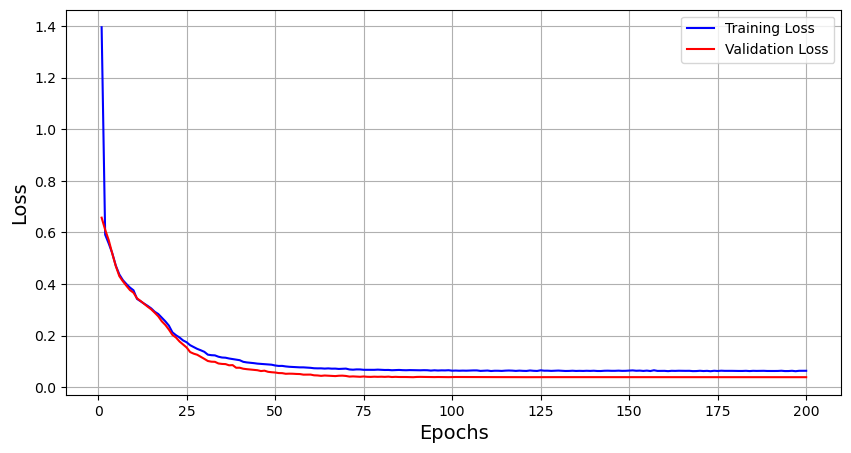

Sampling time 3.0 ms done.
Started with GRU
Epoch 1/200 Done
Total Time Elapsed: 0.02 minutes
Training loss: 1.202196 
Validation loss: 0.691342 
Epoch 2/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 0.632506 
Validation loss: 0.665097 
Epoch 3/200 Done
Total Time Elapsed: 0.07 minutes
Training loss: 0.608684 
Validation loss: 0.640935 
Epoch 4/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.585131 
Validation loss: 0.614067 
Epoch 5/200 Done
Total Time Elapsed: 0.10 minutes
Training loss: 0.556711 
Validation loss: 0.580251 
Epoch 6/200 Done
Total Time Elapsed: 0.12 minutes
Training loss: 0.528873 
Validation loss: 0.547156 
Epoch 7/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.505254 
Validation loss: 0.521872 
Epoch 8/200 Done
Total Time Elapsed: 0.16 minutes
Training loss: 0.490054 
Validation loss: 0.503949 
Epoch 9/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.476398 
Validation loss: 0.491150 
Epoch 10/200 Done
Total Time Elapsed: 

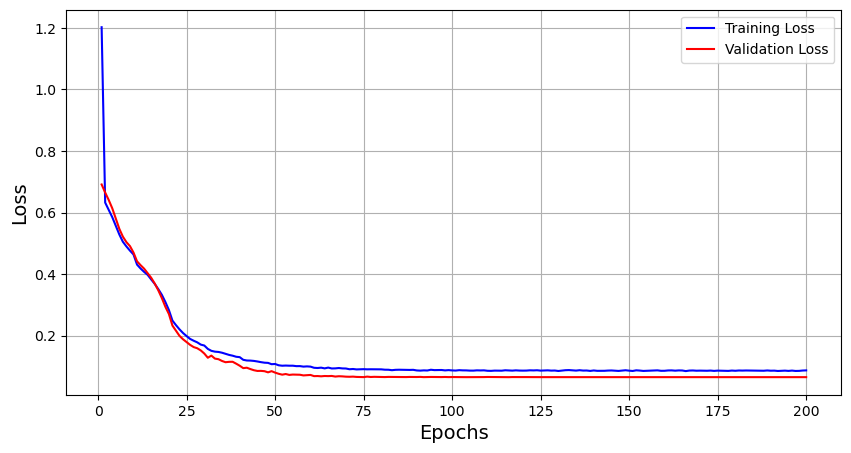

Sampling time 4.0 ms done.
Started with GRU
Epoch 1/200 Done
Total Time Elapsed: 0.03 minutes
Training loss: 1.124213 
Validation loss: 0.713825 
Epoch 2/200 Done
Total Time Elapsed: 0.04 minutes
Training loss: 0.647688 
Validation loss: 0.693835 
Epoch 3/200 Done
Total Time Elapsed: 0.06 minutes
Training loss: 0.629149 
Validation loss: 0.672577 
Epoch 4/200 Done
Total Time Elapsed: 0.08 minutes
Training loss: 0.613453 
Validation loss: 0.656387 
Epoch 5/200 Done
Total Time Elapsed: 0.10 minutes
Training loss: 0.595778 
Validation loss: 0.630126 
Epoch 6/200 Done
Total Time Elapsed: 0.11 minutes
Training loss: 0.580013 
Validation loss: 0.612256 
Epoch 7/200 Done
Total Time Elapsed: 0.14 minutes
Training loss: 0.566765 
Validation loss: 0.594970 
Epoch 8/200 Done
Total Time Elapsed: 0.16 minutes
Training loss: 0.553978 
Validation loss: 0.579271 
Epoch 9/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.542085 
Validation loss: 0.565113 
Epoch 10/200 Done
Total Time Elapsed: 

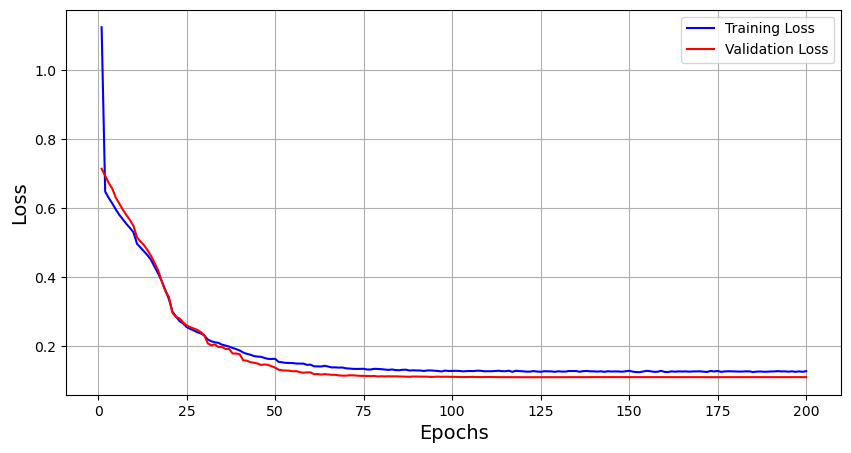

Sampling time 5.0 ms done.


In [51]:
for i in range(len(horizons)):

  # Creating dataset
  train_x, train_y, train_y_clean = dataset_MIMO(H, H_noisy, ts_step[0], lookback, train_samples, 'GRU', horizon=horizons[i])
  test_x, test_y, test_y_clean = dataset_MIMO(H, H_noisy, ts_step[0], lookback, test_samples, 'GRU', test_sc_offset, horizon=horizons[i])
  X = np.append(np.append(train_x, test_x), np.append(train_y, test_y))
  x_max = np.max(X)
  x_min = np.min(X)
  [train_x, train_y] = scaler_transform([train_x, train_y])
  [test_x, test_y] = scaler_transform([test_x, test_y])
  train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), torch.from_numpy(train_y_clean))
  train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle = False)

  # GRU
  if 1:#not performance_df.loc[horizons[i], 'GRU']:
    criterion = nn.MSELoss()
    gru_model = GRUNet(input_dim=next(iter(train_loader))[0].shape[2], hidden_dim = hidden, output_dim = 2*MIMO, n_layers = 3)
    gru_model.to(device)
    optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr_rnn)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=200, step=10)), gamma=0.6)
    training_loss_gru[i, :], validation_loss_gru[i, :] = epoch_loop(gru_model, train_loader, test_x, test_y, test_y_clean,
                                                                                 epochs_rnn, lr_scheduler, model_type = 'GRU')
    performance_df.loc[horizons[i], 'GRU'] = min(validation_loss_gru[i, :])
    performance_df.to_csv(file)
    
    plot_losses(training_loss_gru[i, :], validation_loss_gru[i, :], epochs_rnn, 'GRU')

  #LSTM
  if 0:#not performance_df.loc[horizons[i], 'LSTM']:
    lstm_model = LSTMNet(input_dim=next(iter(train_loader))[0].shape[2], hidden_dim = hidden, output_dim = 2*MIMO, n_layers = 3)
    lstm_model.to(device)
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr_rnn)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=200, step=10)), gamma=0.6)
    training_loss_lstm[i, :], validation_loss_lstm[i, :] = epoch_loop(lstm_model, train_loader, test_x, test_y, test_y_clean,
                                                                                    epochs_rnn, lr_scheduler, model_type = 'LSTM')
    performance_df.loc[horizons[i], 'LSTM'] = min(validation_loss_lstm[i, :])
    performance_df.to_csv(file)

  #CNN
  if 0:#not performance_df.loc[horizons[i], 'CNN']:
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), torch.from_numpy(train_y_clean))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    cnn_model = CNNNet1()
    cnn_model.to(device)
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=200, step=10)), gamma=0.6)
    training_loss_cnn[i, :], validation_loss_cnn[i, :], = epoch_loop(cnn_model, train_loader, test_x, test_y, test_y_clean,
                                                                                 epochs, lr_scheduler, model_type = 'CNN')
    performance_df.loc[horizons[i], 'CNN'] = min(validation_loss_cnn[i, :])
    performance_df.to_csv(file)


  train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[2])
  test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
  #MLP
  train_x = train_x.reshape(train_x.shape[0], train_x.shape[2]*train_x.shape[3]) #MLP
  test_x = test_x.reshape(test_x.shape[0], test_x.shape[2]*test_x.shape[3]) #MLP
  if 0:#not performance_df.loc[horizons[i], 'MLP']:
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), torch.from_numpy(train_y_clean))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    mlp_model = MLPNet(input_dim=2*MIMO*lookback, output_dim = 2*MIMO)
    mlp_model.to(device)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=200, step=10)), gamma=0.6)
    training_loss_mlp[i, :], validation_loss_mlp[i, :] = epoch_loop(mlp_model, train_loader, test_x, test_y, test_y_clean,
                                                                                 epochs, lr_scheduler, model_type = 'MLP')
    performance_df.loc[horizons[i], 'MLP'] = min(validation_loss_mlp[i, :])
    performance_df.to_csv(file)

  # Outdated
  if 1:#not performance_df.loc[horizons[i], 'Outdated']:
    performance_df.loc[horizons[i], 'Outdated'] = np.mean(abs(scaler_inv_transform(test_x[:, -2*MIMO:])-test_y_clean)**2)
    performance_df.to_csv(file)
    NMSE = (np.linalg.norm(scaler_inv_transform(test_x[:, -2*MIMO:])-test_y_clean, axis=1)**2)/(np.linalg.norm(test_y_clean, axis=1)**2)

  print('Sampling time ' + str(horizons[i]/14) + ' ms done.')

In [52]:
## Model parameters
dim_val = 128  # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 1 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 1 # Number of times the decoder layer is stacked in the decoder
input_size = 2*MIMO # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 5  # length of input given to encoder. Can have any integer value.
dec_seq_len = 2 # length of input given to decoder. Can have any integer value.
#enc_seq_len = 10  # length of input given to encoder. Can have any integer value.
#dec_seq_len = 5 # length of input given to decoder. Can have any integer value.
#enc_seq_len = 20  # length of input given to encoder. Can have any integer value.
#dec_seq_len = 10 # length of input given to decoder. Can have any integer value.
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoderdropout_encoder: float=0.2,

Started with TRANS
Epoch 1/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 1.020495 
Validation loss: 0.125204 


c:\Users\qzhou\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 2/200 Done
Total Time Elapsed: 0.10 minutes
Training loss: 0.277008 
Validation loss: 0.131784 
Epoch 3/200 Done
Total Time Elapsed: 0.15 minutes
Training loss: 0.203541 
Validation loss: 0.099155 
Epoch 4/200 Done
Total Time Elapsed: 0.20 minutes
Training loss: 0.151373 
Validation loss: 0.088408 
Epoch 5/200 Done
Total Time Elapsed: 0.25 minutes
Training loss: 0.129160 
Validation loss: 0.063625 
Epoch 6/200 Done
Total Time Elapsed: 0.31 minutes
Training loss: 0.108104 
Validation loss: 0.067819 
Epoch 7/200 Done
Total Time Elapsed: 0.36 minutes
Training loss: 0.097523 
Validation loss: 0.027982 
Epoch 8/200 Done
Total Time Elapsed: 0.41 minutes
Training loss: 0.086455 
Validation loss: 0.077624 
Epoch 9/200 Done
Total Time Elapsed: 0.46 minutes
Training loss: 0.078839 
Validation loss: 0.050172 
Epoch 10/200 Done
Total Time Elapsed: 0.51 minutes
Training loss: 0.082175 
Validation loss: 0.105866 
Epoch 11/200 Done
Total Time Elapsed: 0.56 minutes
Training loss: 0.088152 
Valid

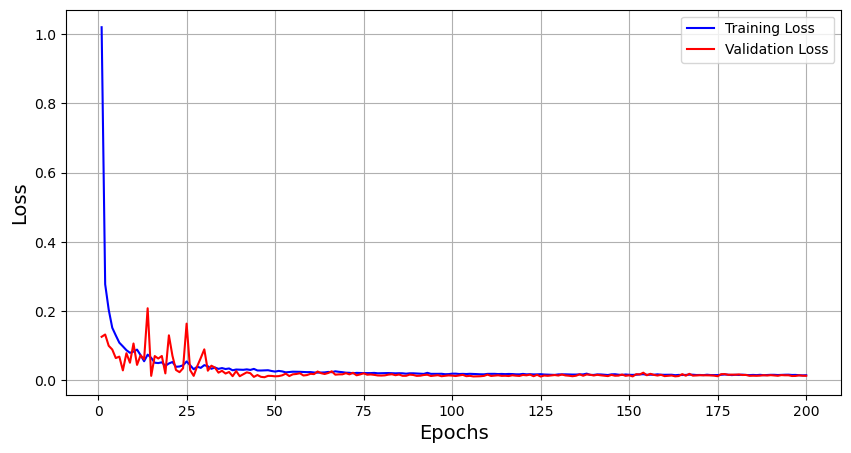

Sampling time 1.0 ms done.
Started with TRANS
Epoch 1/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 1.309750 
Validation loss: 0.230648 
Epoch 2/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.419899 
Validation loss: 0.177434 
Epoch 3/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.333533 
Validation loss: 0.141055 
Epoch 4/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.266374 
Validation loss: 0.138102 
Epoch 5/200 Done
Total Time Elapsed: 0.21 minutes
Training loss: 0.231007 
Validation loss: 0.136484 
Epoch 6/200 Done
Total Time Elapsed: 0.26 minutes
Training loss: 0.197132 
Validation loss: 0.102344 
Epoch 7/200 Done
Total Time Elapsed: 0.30 minutes
Training loss: 0.163196 
Validation loss: 0.089144 
Epoch 8/200 Done
Total Time Elapsed: 0.34 minutes
Training loss: 0.137054 
Validation loss: 0.086940 
Epoch 9/200 Done
Total Time Elapsed: 0.38 minutes
Training loss: 0.124733 
Validation loss: 0.066768 
Epoch 10/200 Done
Total Time Elapsed

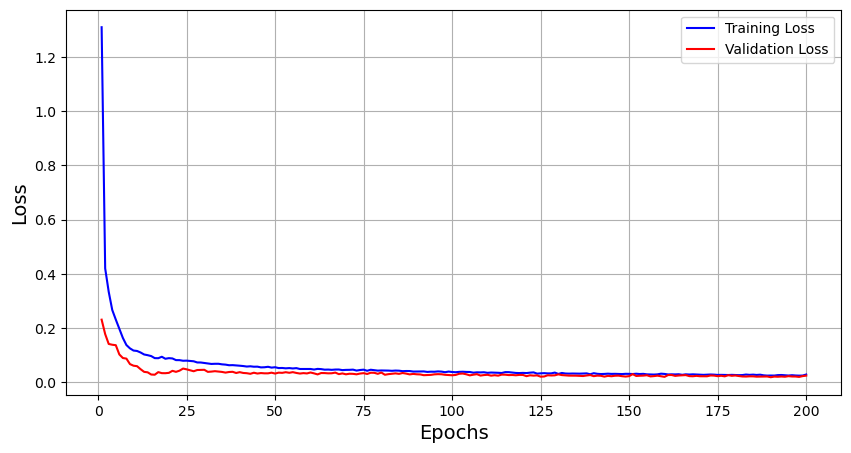

Sampling time 2.0 ms done.
Started with TRANS
Epoch 1/200 Done
Total Time Elapsed: 0.06 minutes
Training loss: 1.171006 
Validation loss: 0.350331 
Epoch 2/200 Done
Total Time Elapsed: 0.11 minutes
Training loss: 0.565132 
Validation loss: 0.322049 
Epoch 3/200 Done
Total Time Elapsed: 0.16 minutes
Training loss: 0.448692 
Validation loss: 0.262568 
Epoch 4/200 Done
Total Time Elapsed: 0.21 minutes
Training loss: 0.381490 
Validation loss: 0.245831 
Epoch 5/200 Done
Total Time Elapsed: 0.26 minutes
Training loss: 0.299680 
Validation loss: 0.202149 
Epoch 6/200 Done
Total Time Elapsed: 0.31 minutes
Training loss: 0.249208 
Validation loss: 0.148372 
Epoch 7/200 Done
Total Time Elapsed: 0.36 minutes
Training loss: 0.214286 
Validation loss: 0.132010 
Epoch 8/200 Done
Total Time Elapsed: 0.41 minutes
Training loss: 0.196112 
Validation loss: 0.096709 
Epoch 9/200 Done
Total Time Elapsed: 0.47 minutes
Training loss: 0.176679 
Validation loss: 0.094590 
Epoch 10/200 Done
Total Time Elapsed

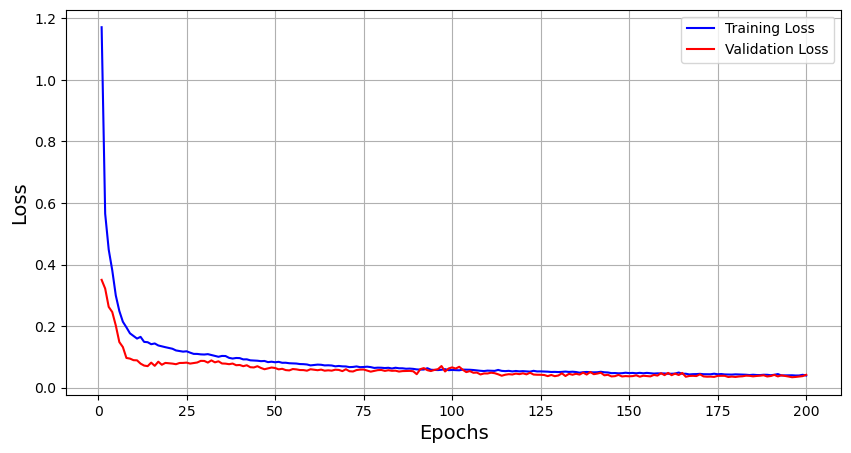

Sampling time 3.0 ms done.
Started with TRANS
Epoch 1/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 1.302314 
Validation loss: 0.484818 
Epoch 2/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.678520 
Validation loss: 0.406771 
Epoch 3/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.528427 
Validation loss: 0.326714 
Epoch 4/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.438568 
Validation loss: 0.240913 
Epoch 5/200 Done
Total Time Elapsed: 0.21 minutes
Training loss: 0.359601 
Validation loss: 0.229486 
Epoch 6/200 Done
Total Time Elapsed: 0.25 minutes
Training loss: 0.327550 
Validation loss: 0.191511 
Epoch 7/200 Done
Total Time Elapsed: 0.30 minutes
Training loss: 0.309732 
Validation loss: 0.207697 
Epoch 8/200 Done
Total Time Elapsed: 0.34 minutes
Training loss: 0.286953 
Validation loss: 0.209904 
Epoch 9/200 Done
Total Time Elapsed: 0.38 minutes
Training loss: 0.262536 
Validation loss: 0.163103 
Epoch 10/200 Done
Total Time Elapsed

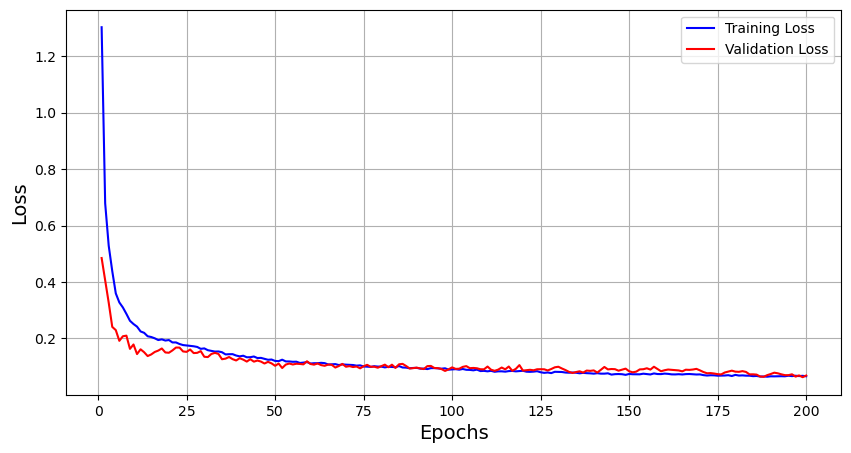

Sampling time 4.0 ms done.
Started with TRANS
Epoch 1/200 Done
Total Time Elapsed: 0.05 minutes
Training loss: 1.561020 
Validation loss: 0.527606 
Epoch 2/200 Done
Total Time Elapsed: 0.09 minutes
Training loss: 0.866387 
Validation loss: 0.520172 
Epoch 3/200 Done
Total Time Elapsed: 0.13 minutes
Training loss: 0.699127 
Validation loss: 0.508140 
Epoch 4/200 Done
Total Time Elapsed: 0.17 minutes
Training loss: 0.577271 
Validation loss: 0.469037 
Epoch 5/200 Done
Total Time Elapsed: 0.21 minutes
Training loss: 0.485475 
Validation loss: 0.428755 
Epoch 6/200 Done
Total Time Elapsed: 0.25 minutes
Training loss: 0.459958 
Validation loss: 0.412943 
Epoch 7/200 Done
Total Time Elapsed: 0.30 minutes
Training loss: 0.432093 
Validation loss: 0.348800 
Epoch 8/200 Done
Total Time Elapsed: 0.34 minutes
Training loss: 0.402790 
Validation loss: 0.334341 
Epoch 9/200 Done
Total Time Elapsed: 0.38 minutes
Training loss: 0.399292 
Validation loss: 0.337708 
Epoch 10/200 Done
Total Time Elapsed

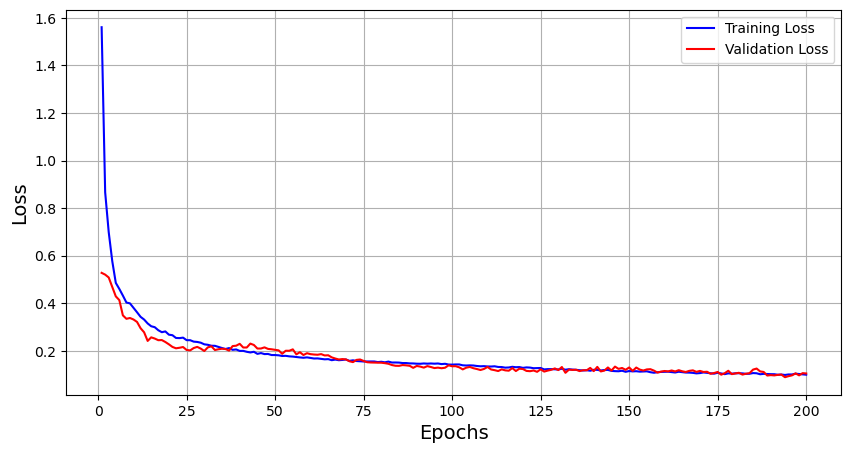

Sampling time 5.0 ms done.


In [53]:
# Implement more decoder sequences

for i in range(len(horizons)):
    output_sequence_length = int(horizons[i]/ts_step[0]) # Length of the target sequence, i.e. how many time steps should your forecast cover
    # Creating dataset
    train_x, train_y, train_y_clean = dataset_MIMO_trans(H, H_noisy, ts_step[0], enc_seq_len, train_samples, 'TRANS', horizon=horizons[i], past=dec_seq_len-output_sequence_length)
    test_x, test_y, test_y_clean = dataset_MIMO_trans(H, H_noisy, ts_step[0], enc_seq_len, test_samples, 'TRANS', test_sc_offset, horizon=horizons[i], past=dec_seq_len-output_sequence_length)
    X = np.append(np.append(train_x, test_x), np.append(train_y, test_y))
    x_max = np.max(X)
    x_min = np.min(X)
    [train_x, train_y] = scaler_transform([train_x, train_y])
    [test_x, test_y] = scaler_transform([test_x, test_y])
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y), torch.from_numpy(train_y_clean))
    train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle = False)

    # Transfomers
    if 1:
      criterion = nn.MSELoss()
      ## Model parameters

      # Make src mask for decoder with size:
      tgt_mask = generate_square_subsequent_mask(
          dim1=dec_seq_len, #output_sequence_length,
          dim2=dec_seq_len, #output_sequence_length
         )
      src_mask = generate_square_subsequent_mask(
          dim1=dec_seq_len, #output_sequence_length,
          dim2=enc_seq_len # Check memory mask and padding
          )

      trans_model = TimeSeriesTransformer(
      dim_val=dim_val,
      input_size=input_size,
      dec_seq_len=dec_seq_len,
      batch_first=True,
      max_seq_len=max_seq_len,
      out_seq_len=output_sequence_length,
      n_decoder_layers=n_decoder_layers,
      n_encoder_layers=n_encoder_layers,
      n_heads=n_heads,
      dropout_encoder=0.1,
      dropout_decoder=0.1,
      dropout_pos_enc=0.1,
      dim_feedforward_encoder=512,#1024,
      dim_feedforward_decoder=512)#)

      trans_model.to(device)

      optimizer = torch.optim.Adam(trans_model.parameters(), lr=lr_trans)
      lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, list(np.arange(start=10, stop=200, step=10)), gamma=0.8)
      optimizer = torch.optim.Adam(trans_model.parameters(), lr=lr_trans)
      training_loss_transformer[i, :], validation_loss_transformer[i, :] = epoch_loop(trans_model, train_loader, test_x, test_y, test_y_clean,
                                                                                                           epochs, lr_scheduler, model_type = 'TRANS')
      performance_df.loc[horizons[i], 'Transformer'] = min(validation_loss_transformer[i, :])
      performance_df.to_csv(file)
      plot_losses(training_loss_transformer[i, :], validation_loss_transformer[i, :], epochs_rnn, 'Transformer')

    train_y = train_y[:,-1,:]
    train_y_clean = train_y_clean[:,-1,:]
    test_y = test_y[:,-1,:]
    test_y_clean = test_y_clean[:,-1,:]
    print('Sampling time ' + str(horizons[i]/14) + ' ms done.')

In [54]:
# Kalman filtering
MIMO = 4
for j in range(len(horizons)):
  train_x, train_y, train_y_clean = dataset_MIMO(H.__deepcopy__(1), H_noisy.__deepcopy__(1), horizons[j], 2*order, test_samples, 'GRU', horizon=horizons[j])
  A = AR_coeff_LS(train_x.__deepcopy__(1), order, 0.1)
  s = int(A.shape[1]/2)
  C = np.zeros([1,s])
  C[0] = 1
  Q = np.eye(s)
  R = 1
  y_pred = np.zeros([A.shape[0], 2*MIMO])
  y_est = np.zeros([A.shape[0], 2*MIMO])
  y_pred_err = np.zeros([len(horizons)])
  for m in range(2*MIMO):
    P = np.eye(s)
    for i in range(A.shape[0]):
      M = np.zeros([s,s])
      M[0,:] = A[i,m,:4]
      M[1,0] = 1
      M[2,1] = 1
      M[3,2] = 1
      x_pred = (M@np.flip(train_x[i,4:,m])).reshape(s,1)
      y_pred[i, m] = x_pred[0]
      P_pred = M@P@M.T + Q
      innovation = (train_y[i,m] - C@x_pred).reshape(1,1)
      S = C@P_pred@C.T + 0
      K = P_pred@C.T@np.linalg.inv(S)
      K = K.reshape(K.shape[0], 1)
      P = (np.eye(s) - C@K)@P_pred
      x_est = x_pred + K@innovation
      y_est[i, m] = x_est[0]
  y_pred_err[j] = np.mean((train_y-y_pred)**2)
  performance_df.loc[horizons[j], 'KF'] = y_pred_err[j]
  performance_df.to_csv(file)
  print(y_pred_err[j])
  print('Horizon ' + str(horizons[j]/14) + ' ms done.')


C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i, m] = x_pred[0]
C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_est[i, m] = x_est[0]
C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:26: RuntimeWarning: overflow encountered in matmul
  S = C@P_pred@C.T + 0
C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:27: RuntimeWarning: overflow encountered in matmul
  K = P_pred@C.T@np.linalg.inv(S)
C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:27: RuntimeWarning:

0.07973913588330993
Horizon 1.0 ms done.
0.14041299084980116
Horizon 2.0 ms done.
0.17662778916220698
Horizon 3.0 ms done.


C:\Users\qzhou\AppData\Local\Temp\ipykernel_12608\2401451791.py:26: RuntimeWarning: invalid value encountered in matmul
  S = C@P_pred@C.T + 0


0.2408469594717679
Horizon 4.0 ms done.
0.3023283694969764
Horizon 5.0 ms done.


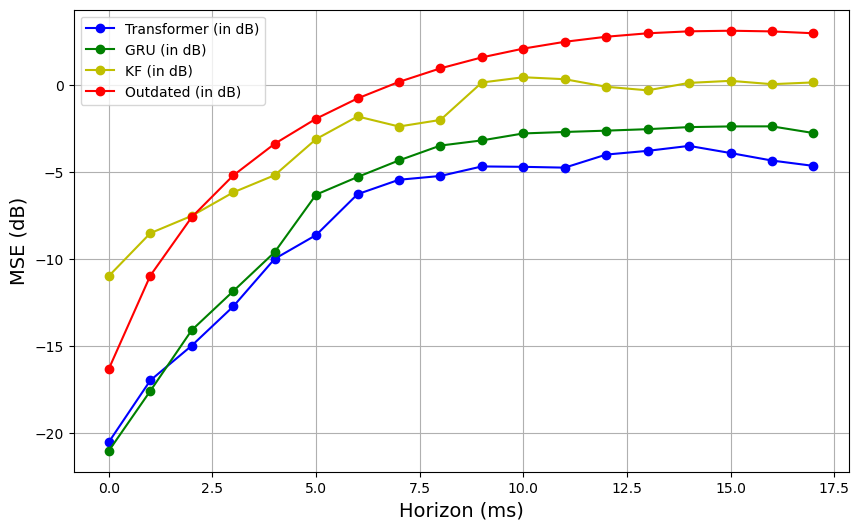

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the uploaded CSV file
file_path = 'performance_SNR20_1_lookback5.csv' 
data = pd.read_csv(file_path)

# Convert the 'Transformer' and 'KF' column values to decibels
data['Transformer_dB'] = 10 * np.log10(data['Transformer'])
data['GRU_dB'] = 10 * np.log10(data['GRU'])
data['Outdated_dB'] = 10 * np.log10(data['Outdated'])
data['KF_dB'] = 10 * np.log10(data['KF'])

# Plot the values with points
plt.figure(figsize=(10, 6))
plt.plot(data['Transformer_dB'], 'bo-', label='Transformer (in dB)')  # Blue circles for Transformer
plt.plot(data['GRU_dB'], 'go-', label='GRU (in dB)')  # Green circles for KF
plt.plot(data['KF_dB'], 'yo-', label='KF (in dB)')  # Yellow circles for LSTM
plt.plot(data['Outdated_dB'], 'ro-', label='Outdated (in dB)')  # Red circles for Outdated
plt.xlabel('Horizon (ms)',fontsize=14)
plt.ylabel('MSE (dB)',fontsize=14)
#plt.title('Comparison of test results in Decibels')
plt.legend()
plt.grid(True)
plt.show()

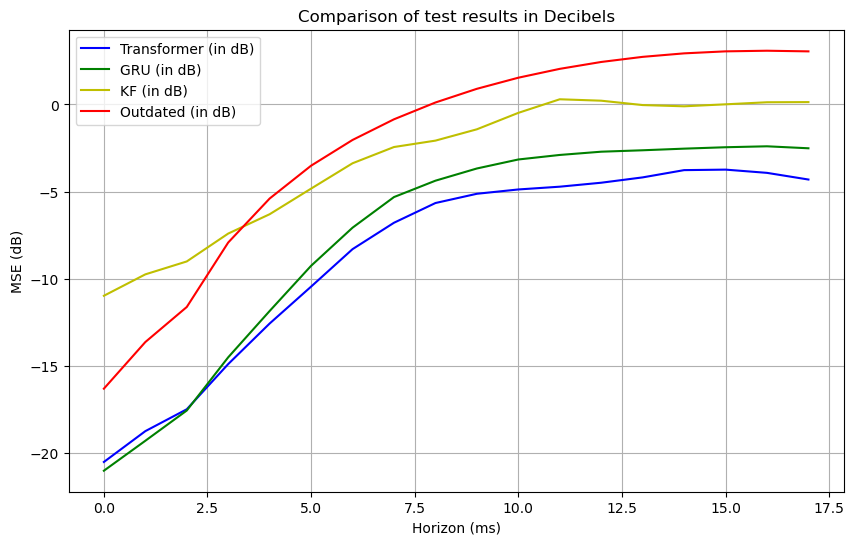

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the uploaded CSV file
file_path = 'performance_SNR20_1_lookback5.csv' 
data = pd.read_csv(file_path)

# Convert the 'Transformer', 'GRU', 'Outdated', and 'KF' column values to decibels
data['Transformer_dB'] = 10 * np.log10(data['Transformer'])
data['GRU_dB'] = 10 * np.log10(data['GRU'])
data['Outdated_dB'] = 10 * np.log10(data['Outdated'])
data['KF_dB'] = 10 * np.log10(data['KF'])

# Define a function to apply moving average
def apply_moving_average(series, window_size=3):
    return series.rolling(window=window_size, min_periods=1).mean()

# Apply moving average to the dB columns
data['Transformer_dB_MA'] = apply_moving_average(data['Transformer_dB'])
data['GRU_dB_MA'] = apply_moving_average(data['GRU_dB'])
data['Outdated_dB_MA'] = apply_moving_average(data['Outdated_dB'])
data['KF_dB_MA'] = apply_moving_average(data['KF_dB'])

# Plot the original and moving average values
plt.figure(figsize=(10, 6))
#plt.plot(data['Transformer_dB'], 'bo-', alpha=0.3, label='Transformer (in dB)')  # Blue circles for Transformer
plt.plot(data['Transformer_dB_MA'], 'b-', label='Transformer (in dB)')  # Smoothed Transformer
#plt.plot(data['GRU_dB'], 'go-', alpha=0.3, label='GRU (in dB)')  # Green circles for GRU
plt.plot(data['GRU_dB_MA'], 'g-', label='GRU (in dB)')  # Smoothed GRU
#plt.plot(data['KF_dB'], 'yo-', alpha=0.3, label='KF (in dB)')  # Yellow circles for KF
plt.plot(data['KF_dB_MA'], 'y-', label='KF (in dB)')  # Smoothed KF
#plt.plot(data['Outdated_dB'], 'ro-', alpha=0.3, label='Outdated (in dB)')  # Red circles for Outdated
plt.plot(data['Outdated_dB_MA'], 'r-', label='Outdated (in dB)')  # Smoothed Outdated

plt.xlabel('Horizon (ms)')
plt.ylabel('MSE (dB)')
plt.title('Comparison of test results in Decibels')
plt.legend()
plt.grid(True)
plt.show()

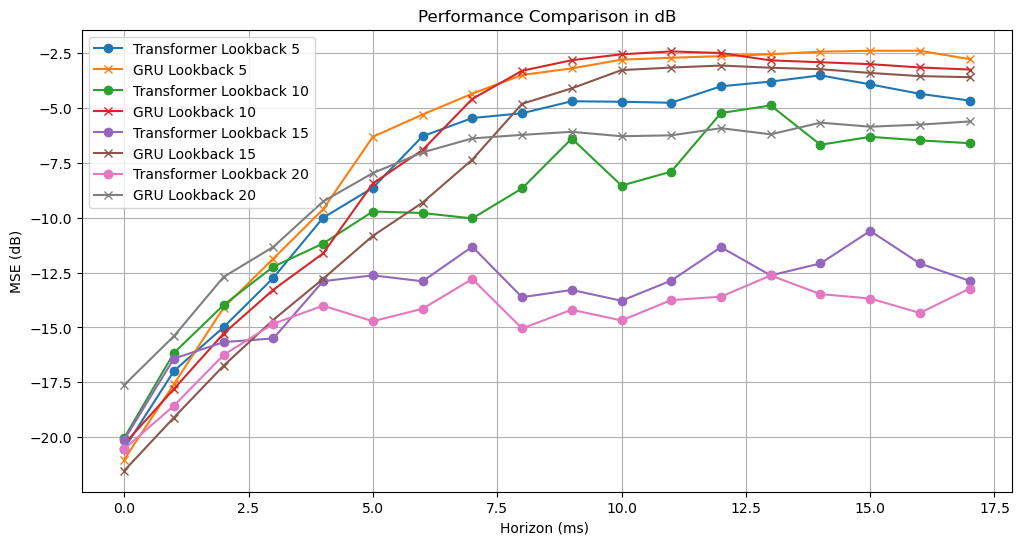

In [135]:
file_paths = [
    'performance_SNR20_1_lookback5.csv',
    'performance_SNR20_1_lookback10.csv',
    'performance_SNR20_1_lookback15.csv',
    'performance_SNR20_1_lookback20.csv'
]
# Function to convert values to decibels
def convert_to_dB(values):
    return 10 * np.log10(values)

# Load the CSV files
lookbacks = [5, 10, 15, 20]  # List of lookback values
dataframes = []  # List to store dataframes
for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    df['Transformer'] = convert_to_dB(df['Transformer'])
    df['GRU'] = convert_to_dB(df['GRU'])
    dataframes.append((lookbacks[i], df))

# Plotting
plt.figure(figsize=(12, 6))
for lookback, df in dataframes:
    plt.plot(df['Transformer'], label=f'Transformer Lookback {lookback}', marker='o')
    plt.plot(df['GRU'], label=f'GRU Lookback {lookback}', marker='x')

plt.title('Performance Comparison in dB')
plt.xlabel('Horizon (ms) ')
plt.ylabel('MSE (dB)')
plt.legend()
plt.grid(True)
plt.show()

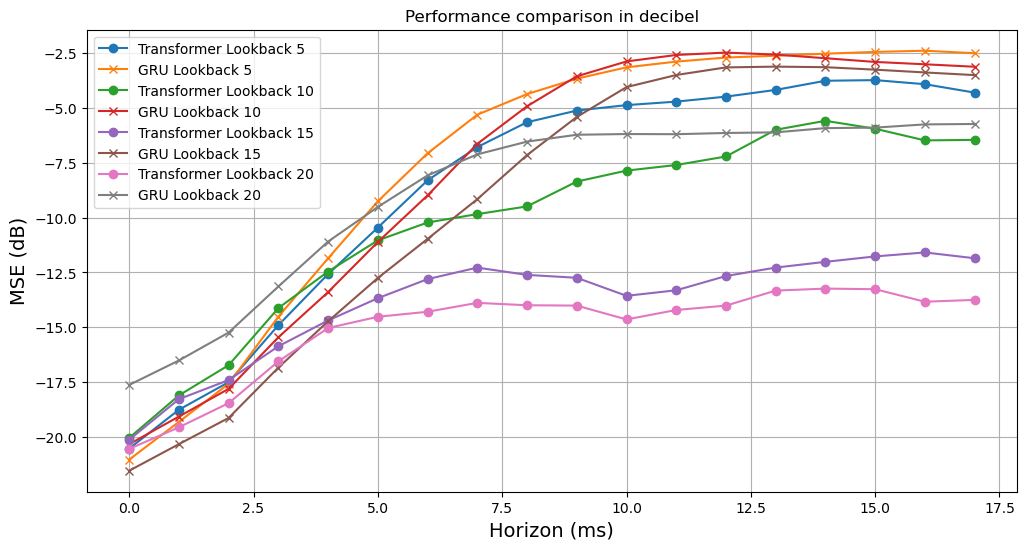

: 

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_paths = [
    'performance_SNR20_1_lookback5.csv',
    'performance_SNR20_1_lookback10.csv',
    'performance_SNR20_1_lookback15.csv',
    'performance_SNR20_1_lookback20.csv'
]

# Function to convert values to decibels
def convert_to_dB(values):
    return 10 * np.log10(values)

# Function to apply moving average
def apply_moving_average(series, window_size=3):
    return series.rolling(window=window_size, min_periods=1).mean()

# Load the CSV files
lookbacks = [5, 10, 15, 20]  # List of lookback values
dataframes = []  # List to store dataframes
for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    df['Transformer'] = convert_to_dB(df['Transformer'])
    df['GRU'] = convert_to_dB(df['GRU'])
    df['Transformer_MA'] = apply_moving_average(df['Transformer'])
    df['GRU_MA'] = apply_moving_average(df['GRU'])
    dataframes.append((lookbacks[i], df))

# Plotting
plt.figure(figsize=(12, 6))
for lookback, df in dataframes:
    plt.plot(df['Transformer_MA'], label=f'Transformer Lookback {lookback}', marker='o')
    plt.plot(df['GRU_MA'], label=f'GRU Lookback {lookback}', marker='x')

plt.title('Performance comparison in decibel')
plt.xlabel('Horizon (ms)',fontsize=14)
plt.ylabel('MSE (dB)',fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


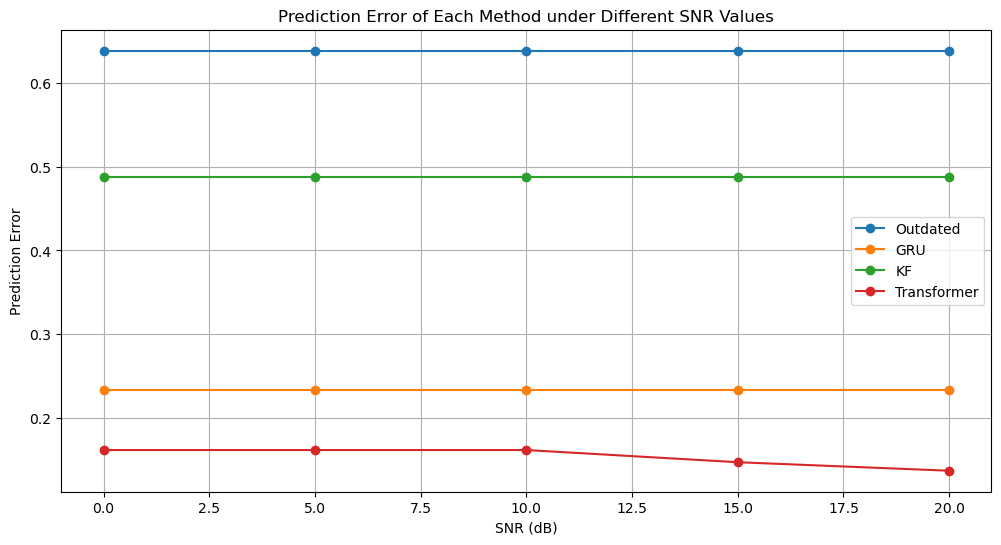

In [173]:

# File paths for the CSV files
file_paths = [
    'performance_SNR0_1_lookback5.csv',
    'performance_SNR5_1_lookback5.csv',
    'performance_SNR10_1_lookback5.csv',
    'performance_SNR15_1_lookback5.csv',
    'performance_SNR20_1_lookback5.csv'  
]

# Corresponding SNR values
snr_values = [0, 5, 10, 15, 20]

# Initialize a dictionary to store the data
methods = ['Outdated', 'GRU', 'KF', 'Transformer']
errors = {method: [] for method in methods}

# Load each file and extract the 6th row for each method
for file_path in file_paths:
    df = pd.read_csv(file_path)
    for method in methods:
        errors[method].append(df[method].iloc[5])  # 6th row is index 5

# Convert the data into a DataFrame for easier plotting
df_errors = pd.DataFrame(errors, index=snr_values)

# Plotting the prediction errors
plt.figure(figsize=(12, 6))
for column in df_errors.columns:
    plt.plot(df_errors.index, df_errors[column], marker='o', label=column)

plt.xlabel('SNR (dB)')
plt.ylabel('Prediction Error')
plt.title('Prediction Error of Each Method under Different SNR Values')
plt.legend()
plt.grid(True)
plt.show()